# Forward Inflation Factor

In prevous attempts ```BetaFactors.ipynb``` had tried to create a $\beta$ factor to the principal components of variuos brakeven term structures. This notebook tries a similar approach but instead of using $\beta$ to the PC it uses $\beta$ to the 5y5y forward inflation swap which used more as a future inflation measure. 

In [1]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

## Accessing Backtest

In [2]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/CommodityInflationFactor/root/src")
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\CommodityInflationFactor\root\src")
from ForwardInflationPCABetaFactor import ForwardInflationPCA
df = ForwardInflationPCA().generate_monthly_factor()

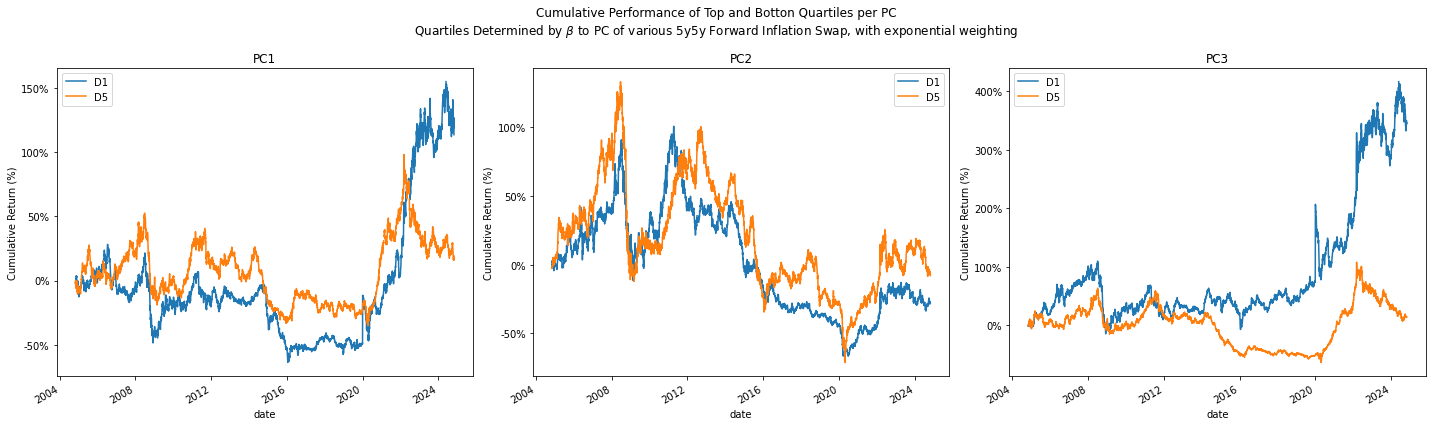

In [12]:
def plot_decile_return(df: pd.DataFrame) -> plt.Figure: 

    variables = df.pc.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))
    
    for variable, ax in zip(variables, axes.flatten()): 
    
        (df.query(
            "pc == @variable")
            [["date", "D1", "D5"]].
            melt(id_vars = "date").
            rename(columns = {"quartile": ""}).
            pivot(index = "date", columns = "", values = "value").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                title  = variable,
                ylabel = "Cumulative Return (%)"))
    
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

    fig.suptitle(
        "Cumulative Performance of Top and Botton Quartiles per PC\nQuartiles Determined by " + 
        r"$\beta$ to PC of various 5y5y Forward Inflation Swap, with exponential weighting")
    plt.tight_layout()

plot_decile_return(df)

In [13]:
def get_decile_sharpe(df: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df.melt(
        id_vars = ["date", "pc"]).
        drop(columns = ["date"]).
        groupby(["pc", "quartile"]).
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())

    return df_out

df_sharpe = get_decile_sharpe(df)

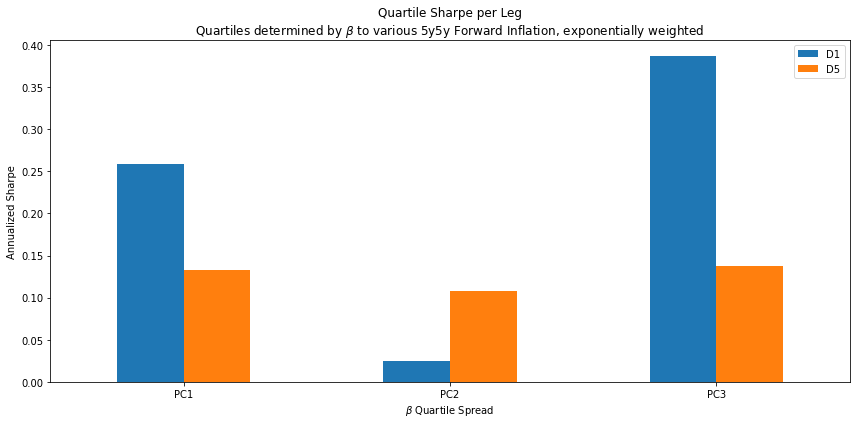

In [16]:
def plot_decile_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 

    (df_sharpe[
        ["pc", "quartile", "sharpe"]].
        rename(columns = {"quartile": ""}).
        pivot(index = "pc", columns = "", values = "sharpe").
        plot(
            kind    = "bar",
            figsize = (12,6),
            ylabel  = "Annualized Sharpe",
            rot     = 0,
            xlabel  = r"$\beta$ Quartile Spread",
            title   = 
                "Quartile Sharpe per Leg\nQuartiles determined by " + 
                r"$\beta$ to various 5y5y Forward Inflation, exponentially weighted"))

    plt.tight_layout()

plot_decile_sharpe(df_sharpe)

# Generate Dollar Neutral Spread

Now same as before, generate dollar neutral spread and in this case its not completely clear which quartile to be long and which quartile to be short so instead just try both spreads.

In [6]:
def generate_spread(df: pd.DataFrame) -> pd.DataFrame: 

    df_d5d1 = (df.assign(
        spread      = lambda x: x.D5 - x.D1,
        spread_name = "D5 - D1"))
    
    df_d1d5 = (df.assign(
        spread      = lambda x: x.D1 - x.D5,
        spread_name = "D1 - D5"))
    
    df_combined = (pd.concat([
        df_d5d1, df_d1d5]).
        drop(columns = ["D1", "D5"]))

    return df_combined

df_spread = generate_spread(df)

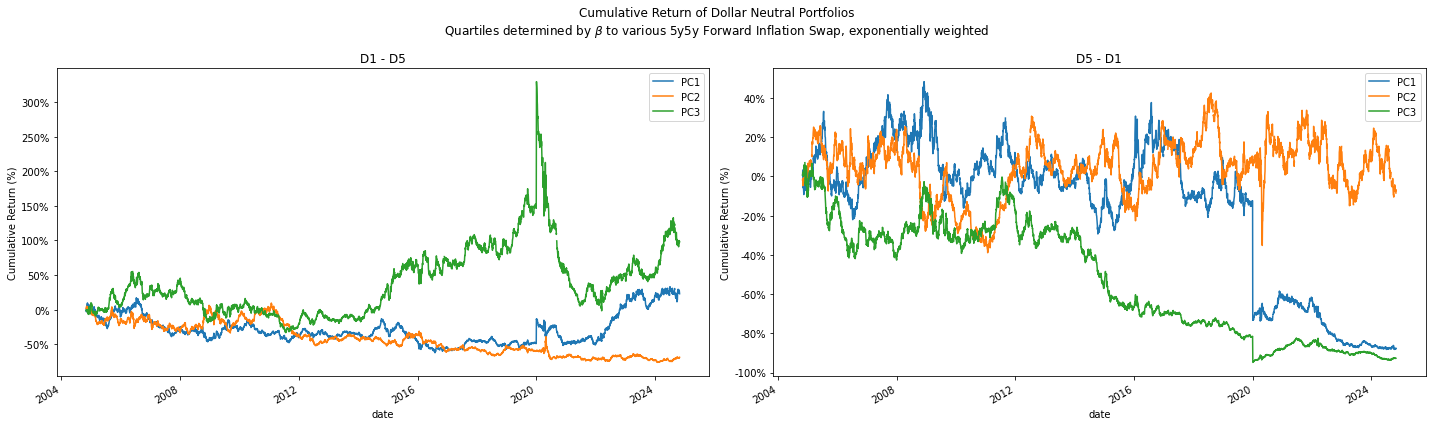

In [17]:
def plot_spread(df_spread: pd.DataFrame) -> plt.Figure:

    spreads   = df_spread.spread_name.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(spreads), figsize = (20,6))
    
    for spread, ax in zip(spreads, axes.flatten()): 
    
        (df_spread.query(
            "spread_name == @spread").
            drop(columns = ["spread_name"]).
            rename(columns = {"pc": ""}).
            pivot(index = "date", columns = "", values = "spread").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                ylabel = "Cumulative Return (%)",
                title  = spread))
    
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    
    fig.suptitle(
        "Cumulative Return of Dollar Neutral Portfolios\nQuartiles determined by " + 
        r"$\beta$ to various 5y5y Forward Inflation Swap, exponentially weighted")
    plt.tight_layout()

plot_spread(df_spread)

In [18]:
def get_spread_sharpe(df_spread: pd.DataFrame) -> pd.DataFrame: 

    df_sharpe = (df_spread.drop(
        columns = ["date"]).
        groupby(["pc", "spread_name"]).
        agg(["mean", "std"])
        ["spread"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())

    return df_sharpe

df_spread_sharpe = get_spread_sharpe(df_spread)

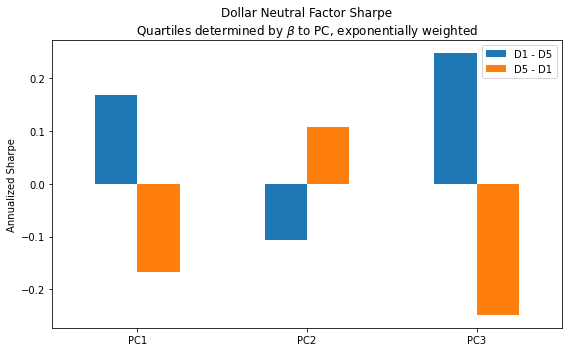

In [21]:
def plot_spread_sharpe(df_spread_sharpe: pd.DataFrame) -> plt.Figure: 


    (df_spread_sharpe.drop(
        columns = ["mean_rtn", "std_rtn"]).
        rename(columns = {"spread_name": ""}).
        pivot(index = "pc", columns = "", values = "sharpe").
        plot(
            kind    = "bar",
            ylabel  = "Annualized Sharpe",
            rot     = 0,
            xlabel  = "",
            figsize = (8,5),
            title   =  
                "Dollar Neutral Factor Sharpe\nQuartiles determined by " + 
                r"$\beta$ to various , exponentially weighted"))

    plt.tight_layout()

plot_spread_sharpe(df_spread_sharpe)